##### In this project, we show how to implement a music genre classifier from scratch in TensorFlow/Keras using features calculated by the Librosa library.

##### We used the GTZAN dataset that ontains a range of recordings reflecting different circumstances, the files were gathered between year 2000 and 2001 from a number of sources, including personal CDs, radio, and microphone recordings.
##### The dataset contains 10 classes, each class with a 100 of different 30 seconds audio files. The classes are: blues, classical, country, disco, hip-hop, jazz, metal, pop, reggae and rock.

In [2]:
import warnings
warnings.filterwarnings("ignore", category = FutureWarning)

In [ ]:
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification

#### Importing python libraries


In [3]:
import os
import numpy
import tensorflow as tf
import librosa
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import random
from pydub import AudioSegment
import librosa
import librosa.display
import gradio as gr
from pydub import AudioSegment


In [ ]:
genres=['blues','classical','country', 'disco','hiphop','jazz', 'metal','pop','reggae', 'rock']
for i,genre in enumerate(genres):
    y,sr=librosa.load("Data/genres_original/"+genre+'/'+genre+'.00005.wav',duration=5.0,sr=None,)
    time=np.linspace(0,len(y)/sr,num=len(y))
    plt.figure(i+1)
    plt.title(genre+" Signal Wave")
    plt.yticks(ticks=[])
    plt.plot(time,y)
    plt.savefig(fname=genre+'_time_domain')
    plt.show()

##### Each music genre is characterized by its own specifications: pitch, melody, chord progressions and instrumentation type. To have a reliable classification, we will use a set of features that capture the essence of these elements, giving the model a better chance to be properly trained to distinguish between genres.
#### In this tutorial, we'll construct four features that we will be used to create a single feature vector related to each file that our model will be trained on.

##### These features are:

* Mel frequency Cepstral coefficiens (MFCC)
    * MFCC is used to represent the spectral characteristics of sound, and a set of coefficients that capture the shape of the power spectrum of a sound signal.
    
* Mel spectogram (get_melspectrogram)
    * offers a good representation of the frequencies that humans typically hear
* Chroma vector (get_chroma_vector)
    * The Chroma features vector is constructed by having the full spectrum projected onto 12 bins that reflect the 12 unique semitones (or Chroma) of the musical octave.
* Tonal Centroid Features (get_tonnetz)
    * The tonnetz tonal centroids — the “central” tones. These are features that help in Detecting Harmonic Change in Musical Audio or variances due to tones in audio.


In [4]:
def get_mfcc(wav_file_path):
    y, sr = librosa.load(wav_file_path, offset=0, duration=30)
    mfcc = numpy.array(librosa.feature.mfcc(y=y, sr=sr))
    return mfcc

#### ploting the MFCC image of an example file

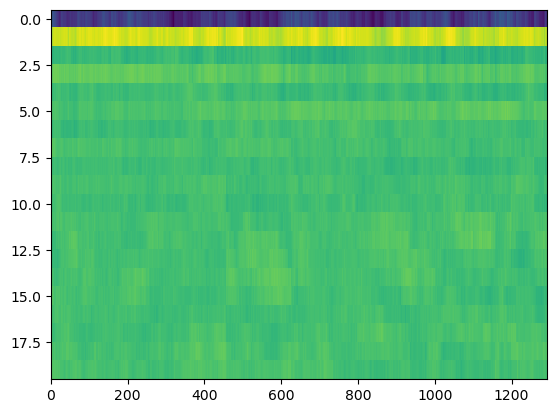

In [5]:
example_File = "Data/genres_original/classical/classical.00001.wav"
mfcc = get_mfcc(example_File)
plt.imshow(mfcc, interpolation='nearest', aspect='auto')
plt.show()

In [6]:
def get_tonnetz(wav_file_path):
  y, sr = librosa.load(wav_file_path)
  tonnetz = numpy.array(librosa.feature.tonnetz(y=y, sr=sr))
  return tonnetz

In [7]:
def get_chroma_vector(wav_file_path):
  y, sr = librosa.load(wav_file_path)
  chroma = numpy.array(librosa.feature.chroma_stft(y=y, sr=sr))
  return chroma

In [8]:
def get_melspectrogram(wav_file_path):
  y, sr = librosa.load(wav_file_path, offset=0, duration=30, )
  melspectrogram = numpy.array(librosa.feature.melspectrogram(y=y, sr=sr))
  return melspectrogram

#### extract the envelope (min and max) and the mean of each feature along the time axis. 

In [9]:
def get_feature(file_path):
  # Extracting MFCC feature
  mfcc = get_mfcc(file_path)
  mfcc_mean = mfcc.mean(axis=1)
  mfcc_min = mfcc.min(axis=1)
  mfcc_max = mfcc.max(axis=1)
  mfcc_feature = numpy.concatenate( (mfcc_mean, mfcc_min, mfcc_max) )

  # Extracting Mel Spectrogram feature
  melspectrogram = get_melspectrogram(file_path)
  melspectrogram_mean = melspectrogram.mean(axis=1)
  melspectrogram_min = melspectrogram.min(axis=1)
  melspectrogram_max = melspectrogram.max(axis=1)
  melspectrogram_feature = numpy.concatenate( (melspectrogram_mean, melspectrogram_min, melspectrogram_max) )

  # Extracting chroma vector feature
  chroma = get_chroma_vector(file_path)
  chroma_mean = chroma.mean(axis=1)
  chroma_min = chroma.min(axis=1)
  chroma_max = chroma.max(axis=1)
  chroma_feature = numpy.concatenate( (chroma_mean, chroma_min, chroma_max) )

  # Extracting tonnetz feature
  tntz = get_tonnetz(file_path)
  tntz_mean = tntz.mean(axis=1)
  tntz_min = tntz.min(axis=1)
  tntz_max = tntz.max(axis=1)
  tntz_feature = numpy.concatenate( (tntz_mean, tntz_min, tntz_max) ) 
  
  feature = numpy.concatenate( (chroma_feature, melspectrogram_feature, mfcc_feature, tntz_feature) )
  return feature

#### Calculating features for the full Dataset, and we'll use three genres to train our model on:  blues , classical , country ,  disco , hiphop , jazz ,  metal , pop , reggae , and rock 

In [11]:
dir = 'Data/genres_original/'
#genres = ['reggae','classical','rock']
genres = ['blues','classical','country', 'disco','hiphop','jazz', 'metal','pop','reggae', 'rock']
features = []
labels = []
for genre in genres:
    print("Calculating features for genre : " + genre)
    for file in os.listdir(dir+"/"+genre):
        file_path = dir+"/"+genre+"/"+file

        features.append(get_feature(file_path))
        label = genres.index(genre)
        labels.append(label)

Calculating features for genre : blues
Calculating features for genre : classical
Calculating features for genre : country
Calculating features for genre : disco
Calculating features for genre : hiphop
Calculating features for genre : jazz
Calculating features for genre : metal
Calculating features for genre : pop
Calculating features for genre : reggae
Calculating features for genre : rock


In [35]:
X = numpy.array(features)
y = numpy.array(labels)


In [36]:
X.shape, y.shape

((1000, 498), (1000,))

#### Splitting the Dataset into training, and testing parts

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)
len(X_train), len(X_test), len(y_train), len(y_test)

(700, 300, 700, 300)

#### Training the model

In [38]:
def training_model(model, epchs, optimizer):
    batch_size = 128
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy",
                  metrics = 'accuracy')
    return model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epchs,
                     batch_size=batch_size)

In [88]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1024, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(512, activation='relu'),

    tf.keras.layers.Dense(256, activation='relu'),
    
    tf.keras.layers.Dense(64, activation='relu'),

    tf.keras.layers.Dense(len(np.unique(y)), activation='softmax')
    ])
model_history = training_model(model=model, epchs=200, optimizer='adam')

Epoch 1/200
6/6 [==============================] - 1s 56ms/step - loss: 123.9709 - accuracy: 0.1629 - val_loss: 75.6467 - val_accuracy: 0.2067
Epoch 2/200
6/6 [==============================] - 0s 13ms/step - loss: 40.2465 - accuracy: 0.1957 - val_loss: 22.9160 - val_accuracy: 0.2467
Epoch 3/200
6/6 [==============================] - 0s 16ms/step - loss: 16.4064 - accuracy: 0.2986 - val_loss: 10.6356 - val_accuracy: 0.2833
Epoch 4/200
6/6 [==============================] - 0s 16ms/step - loss: 8.2881 - accuracy: 0.3243 - val_loss: 7.2145 - val_accuracy: 0.2967
Epoch 5/200
6/6 [==============================] - 0s 16ms/step - loss: 6.0061 - accuracy: 0.3171 - val_loss: 5.0379 - val_accuracy: 0.2100
Epoch 6/200
6/6 [==============================] - 0s 16ms/step - loss: 4.1384 - accuracy: 0.2900 - val_loss: 2.6060 - val_accuracy: 0.1700
Epoch 7/200
6/6 [==============================] - 0s 15ms/step - loss: 2.5004 - accuracy: 0.2100 - val_loss: 2.2031 - val_accuracy: 0.1667
Epoch 8/200
6

#### Training the model

In [89]:
score  = model.evaluate(X_test, y_test, batch_size=128)
print('Accuracy : ' + str(score[1]*100) + '%')

3/3 [==============================] - 0s 8ms/step - loss: 5.2228 - accuracy: 0.5300
Accuracy : 52.99999713897705%


####  we installed the pydub library that we'll use to crop the wav file size of dersired song
#### We crop the wav file to a 30 seconds section, from 01:00:00 tp 01:30:00. Then, save the resulting file.
#### Then, we use our previously trained model to classify the audio music genre of the audio.

In [90]:
def music_type(wav_file):
    
    if os.path.exists("audio_sample_30s.wav"):
        os.remove("audio_sample_30s.wav")
    
    
    n = random. randint(0,256)
    base_dir = os.getcwd()
    t1 = 60000 #Works in milliseconds
    t2 = 90000
    waveFile = AudioSegment.from_file(wav_file, format = "wav")
    waveFile = waveFile[t1:t2]
    waveFile.export('audio_sample_30s.wav', format="wav")
    file_path= os.path.join(os.getcwd(), wav_file)
    feature = get_feature(file_path)
    y = model.predict(feature.reshape(1,498), verbose=0)
    ind = numpy.argmax(y)
    
    os.remove("audio_sample_30s.wav")
    print(type(ind))
    return  str(genres[ind]).capitalize()
    


#### Finally, we get the expected result:

In [91]:
music_type("System Of A Down - Chop Suey!.wav")

<class 'numpy.int64'>


'Hiphop'

#### Finally, we get the expected result:

In [92]:
music_type("Adele - Rolling in the Deep.wav")

<class 'numpy.int64'>


'Pop'

#### GUI interface with Gradio and use Adele - Rolling in the Deep.wav as example

In [85]:
inputs=gr.Audio(label="Input Audio", type="filepath")
outputs= gr.TextArea(label='Music/Song Genre')
title='Music Genre Classification'
description='This is a Music Genre Classification model based on a novel ensemble approach'
examples = [
    ['D:\Downloads\Compressed\Music_Genre_Classification\Adele - Rolling in the Deep.wav']
]

gr.Interface(music_type, inputs, outputs, title=title, description=description, examples=examples, theme=gr.themes.Monochrome(), allow_flagging='never').launch()


Running on local URL:  http://127.0.0.1:7875

To create a public link, set `share=True` in `launch()`.
